<a href="https://colab.research.google.com/github/kimdesok/DeepPATH/blob/master/ImageNet_VGG_ResNet_Inception_Xception_on_MS_COCO_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
# import the necessary packages
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception # TensorFlow ONLY
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import argparse
import cv2

#Dataset preparation
>* Download MS COCO dataset
>* Common objects in context (COCO) is a large-scale object detection, segmentation, and captioning dataset.

reference: https://blog.cambridgespark.com/50-free-machine-learning-datasets-image-datasets-241852b03b49

In [84]:
!wget http://images.cocodataset.org/zips/val2017.zip 
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2022-01-24 06:46:39--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.130.145
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.130.145|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip.1’

val2017.zip.1       100%[===================>] 777.80M  95.4MB/s    in 8.1s    

2022-01-24 06:46:47 (95.7 MB/s) - ‘val2017.zip.1’ saved [815585330/815585330]

--2022-01-24 06:46:48--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.227.121
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.227.121|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip.1’

annotations_trainva 100%[===================>] 241.19M  96.5MB/s    in 2.5s  

In [ ]:
!unzip  /content/annotations_trainval2017.zip
!unzip  /content/val2017.zip

In [61]:
!pip install setuptools
!pip install cython

In [152]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
from skimage.transform import resize
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
dataDir='.'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

# initialize COCO api for instance annotations
coco=COCO(annFile)
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))


loading annotations into memory...
Done (t=0.96s)
creating index...
index created!
COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
accessory furniture person food vehicle kitchen outdoor animal appliance indoor sports electronic


[1]
[532481, 458755, 385029, 311303, 393226, 532493, 8211, 327701, 188439, 434204, 401446, 213033, 466986, 213035, 319534, 516143, 32817, 532530, 188465, 434230, 475191, 254016, 131138, 16451, 81988, 376900, 507975, 434247, 204871, 516173, 122962, 98392, 442456, 32861, 213086, 442463, 311392, 311394, 49259, 221291, 442480, 368752, 319607, 417911, 32887, 450686, 32901, 270474, 139, 180383, 82085, 385190, 524456, 90284, 32941, 188592, 229553, 278705, 213171, 336053, 549055, 114884, 508101, 65736, 303305, 344268, 532690, 360661, 16598, 73946, 114907, 426203, 278749, 516318, 229601, 295138, 467176, 319721, 352491, 33005, 458992, 475387, 393469, 57597, 426241, 540932, 106757, 65798, 180487, 213255, 147725, 418062, 147729, 377113, 229659, 147740, 426268, 434459, 205105, 565563, 278848, 368961, 352582, 57672, 74058, 123213, 33104, 336209, 180560, 483667, 8532, 270677, 262487, 491867, 475484, 393569, 549220, 336232, 74092, 467315, 131444, 434548, 532855, 442746, 541055, 426376, 336265, 303499,

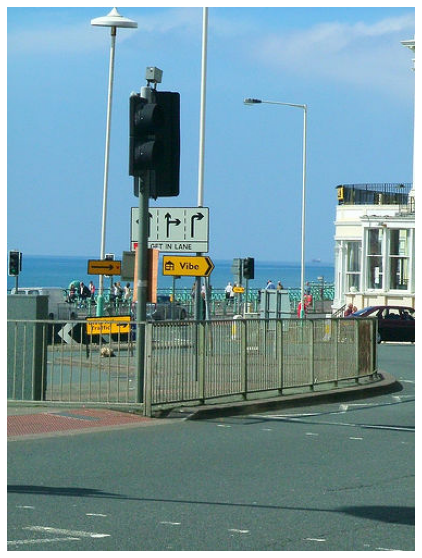

In [153]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person','matchstick','digital_clock']);
print(catIds)
imgIds = coco.getImgIds(catIds=catIds );
print(imgIds)
#imgIds = coco.getImgIds(imgIds = [139])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

# load and display image
#I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

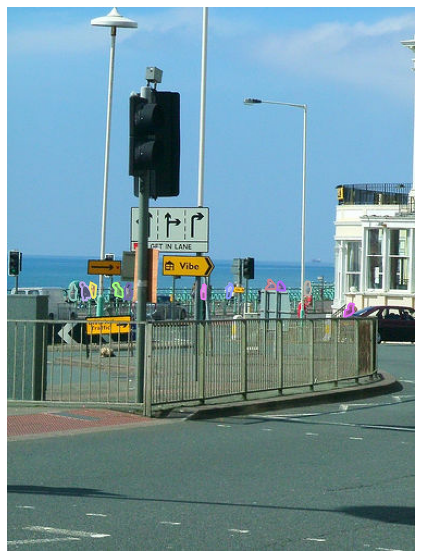

In [154]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


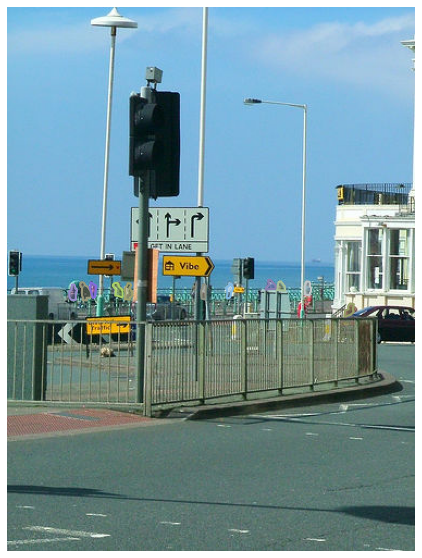

In [155]:
# initialize COCO api for person keypoints annotations
annFile = '{}/annotations/person_keypoints_{}.json'.format(dataDir,dataType)
coco_kps=COCO(annFile)

# load and display keypoints annotations
plt.imshow(I); plt.axis('off')
ax = plt.gca()
annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco_kps.loadAnns(annIds)
coco_kps.showAnns(anns)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
A parking lot is on the side of the ocean.
A street light attached to a pole next to a street and a sidewalk railing.
A traffic light and a signpost at a crossroads intersection near a waterway.
A view from the street overlooks the ocean.
An assortment of street lights and signs next to an ocean.


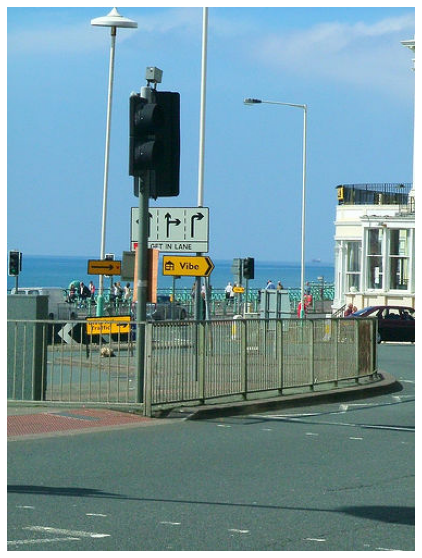

In [156]:
# initialize COCO api for caption annotations
annFile = '{}/annotations/captions_{}.json'.format(dataDir,dataType)
coco_caps=COCO(annFile)

# load and display caption annotations
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.imshow(I); plt.axis('off'); plt.show()

In [157]:
# define a dictionary that maps model names to their classes
# inside Keras
MODELS = {
	"vgg16": VGG16,
	"vgg19": VGG19,
	"inception": InceptionV3,
	"xception": Xception, # TensorFlow ONLY
	"resnet": ResNet50
}
# 224×224 input images for VGG!6, VGG!9 and RestNet
# 299x299 input images for Inception V3 and Xception

# initialize the input image shape (224x224 pixels) along with
# the pre-processing function (this might need to be changed
# based on which model we use to classify our image)
#Select a model from the above MODELS dict.
inputModel = 'resnet'

# path to the image folder
#inputPath = '/content/val2017'
inputShape = (224, 224)
preprocess = imagenet_utils.preprocess_input
# if we are using the InceptionV3 or Xception networks, then we
# need to set the input shape to (299x299) [rather than (224x224)]
# and use a different image pre-processing function
if inputModel in ("inception", "xception"):
	inputShape = (299, 299)
	preprocess = preprocess_input
print(inputShape)

# load our the network weights from disk (NOTE: if this is the
# first time you are running this script for a given network, the
# weights will need to be downloaded first -- depending on which
# network you are using, the weights can be 90-575MB, so be
# patient; the weights will be cached and subsequent runs of this
# script will be *much* faster)
print("[INFO] loading {}...".format(inputModel))
Network = MODELS[inputModel]
model = Network(weights="imagenet")

(224, 224)
[INFO] loading resnet...


In [167]:
inputPath = img['coco_url']
print(inputPath)

http://images.cocodataset.org/val2017/000000094751.jpg


[INFO] loading and pre-processing images from http://images.cocodataset.org/val2017/000000094751.jpg...
(224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


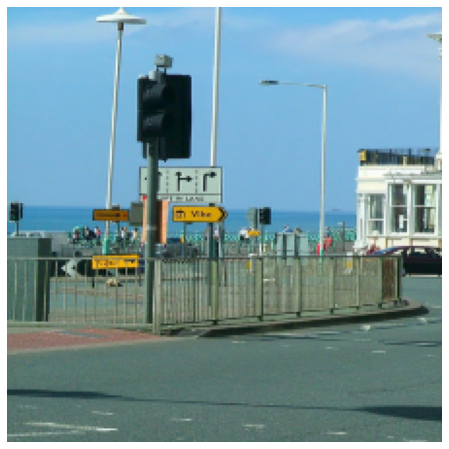

In [170]:
# load the input image using the Keras helper utility while ensuring
# the image is resized to `inputShape`, the required input dimensions
# for the ImageNet pre-trained network
#inputPath =  img['coco_url'] #r'/content/val2017/000000000139.jpg'
print("[INFO] loading and pre-processing images from {}...".format(inputPath))
image = io.imread(inputPath) #load_img(inputPath, target_size=inputShape)

image = resize(image, inputShape)
plt.axis('off')
plt.imshow(image)

image = img_to_array(image)
print(image.shape)
# our input image is now represented as a NumPy array of shape
# (inputShape[0], inputShape[1], 3) however we need to expand the
# dimension by making the shape (1, inputShape[0], inputShape[1], 3)
# so we can pass it through the network
image = np.expand_dims(image, axis=0)
print(image.shape)
# pre-process the image using the appropriate function based on the
# model that has been loaded (i.e., mean subtraction, scaling, etc.)
image = preprocess(image)
print(image.shape)



In [160]:
# classify the image
print("[INFO] classifying {} with '{}'...".format(inputPath, inputModel))
preds = model.predict(image)
P = imagenet_utils.decode_predictions(preds)
# loop over the predictions and display the rank-5 predictions +
# probabilities to our terminal
for (i, (imagenetID, label, prob)) in enumerate(P[0]):
	print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))

[INFO] classifying http://images.cocodataset.org/val2017/000000108253.jpg with 'resnet'...
1. web_site: 6.36%
2. matchstick: 6.12%
3. digital_clock: 5.18%
4. nematode: 4.00%
5. spotlight: 3.44%


In [1]:
# load the image via OpenCV, draw the top prediction on the image,
# and display the image to our screen

from google.colab.patches import cv2_imshow

#orig = cv2.imread(inputPath)
(imagenetID, label, prob) = P[0][0]
text= "Label: {}, {:.2f}%".format(label, prob * 100)
plt.text(50, 50, text, dict(color='red', va='center', ha='center'))
plt.axis('off')
plt.imshow(I)
#cv2.waitKey(0)

NameError: ignored

In [162]:
%matplotlib inline
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [163]:
annType = ['segm','bbox','keypoints']
annType = annType[1]      #specify type here
prefix = 'person_keypoints' if annType=='keypoints' else 'instances'
print( 'Running demo for *%s* results.'%(annType) )

#initialize COCO ground truth api
dataDir='.'
dataType='val2017'
annFile = '%s/annotations/%s_%s.json'%(dataDir,prefix,dataType)
cocoGt=COCO(annFile)

Running demo for *bbox* results.
loading annotations into memory...
Done (t=0.59s)
creating index...
index created!


In [164]:
#initialize COCO detections api
resFile='%s/results/%s_%s_fake%s100_results.json'
resFile = resFile%(dataDir, prefix, dataType, annType)
#cocoDt=cocoGt.loadRes(resFile)

In [165]:
imgIds=sorted(cocoGt.getImgIds())
imgIds=imgIds[0:100]
imgId = imgIds[np.random.randint(100)]

In [166]:
# running evaluation
#cocoEval = COCOeval(cocoGt,cocoDt,annType)
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

NameError: ignored